## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


This project was an exercise in multiple linear regression, using the Housing dataset from King County. The process follows the OSEM-I Data Science work flow.

The first step is to upload the data and load the numpy/pandas libraries, then take a look at what the dataframe looks like, inspect column names, and drop unnecessary columns.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')
kchouse = pd.read_csv('data/kc_house_data.csv')
kchouse.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [ ]:
kchouse.info()

In [2]:
kc_new = kchouse.drop(['date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1)
kc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           21597 non-null  int64  
 1   price        21597 non-null  float64
 2   bedrooms     21597 non-null  int64  
 3   bathrooms    21597 non-null  float64
 4   sqft_living  21597 non-null  int64  
 5   sqft_lot     21597 non-null  int64  
 6   floors       21597 non-null  float64
 7   waterfront   19221 non-null  float64
 8   condition    21597 non-null  int64  
 9   grade        21597 non-null  int64  
 10  yr_built     21597 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 1.8 MB


The next steps, Scrub and Explore, do mean separate things, but tend go hand in hand. As we explore more representations of our data, we gain more particular insight into its characteristics.

I noticed there were null values in the waterfront column. The values 1 and 0 represent if the property is on a waterfront or not. I'mmaking and educated assumption that that means there is no waterfront, so I changed the null values to a 0.

In [ ]:
kc_new.isna().value_counts()

In [3]:
kc_new['waterfront'] = kc_new['waterfront'].fillna(0.0)
kc_new.isna().value_counts()

id     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  condition  grade  yr_built
False  False  False     False      False        False     False   False       False      False  False       21597
dtype: int64

I wanted to make sure there was one entry per ID, and drop any double-entries

In [ ]:
kc_new['id'].value_counts()

In [4]:
kc_new.drop_duplicates(subset = 'id', inplace = True)

In [ ]:
kc_new.info()

In [ ]:
kc_new.describe()

In [ ]:
#some notes: # Mean price is $540,296.57 
             # std $367368.14
             # min $78,000.0 
             # 25% $322,000.0
             # 50% $450,000.0,
             # 75% $645000.0
             # max $7,700,000.0

As we continue to explore our data, it's important to keep in mind whether the essential assumptions for Linear Regression are met. We require Linearity between X and Y, lack of Multicolinearity, Homoscedascity, and Normality. 

A scatter matrix is helpful to get a glance of how the independent variables may interact with each other and address multicolinearity

In [ ]:
pd.plotting.scatter_matrix(kc_new, figsize=[14,14])

I created a correlation heat map to visualize the Pearson Correlation coefficients between both independent and dependent variables.  

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = kc_new.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(14, 12))

    ax = sns.heatmap(corr, mask=mask, square=True, annot = True, cmap = 'coolwarm')

Check for colinearity between independent variables

In [ ]:
df = kc_new.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates()
df[(df.cc>.75) & (df.cc <1)]

In [ ]:
def hist_and_scatter(feature, title, featurename):
    figure, ax = plt.subplots(1, 2, figsize=(8, 6))
    ax[0].hist(feature, bins = 20)
    ax[1].scatter(feature, kc_new['price'])
    ax[0].set_xlabel(featurename)
    ax[1].set_xlabel(featurename)
    ax[1].set_ylabel('price')
    figure.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.9])
    plt.show()

In [ ]:
for col in kc_new.columns:
    hist_and_scatter(
        kc_new[col], f'Distribution and Relationship between Price and {col}', col)

In [ ]:
corrs = kc_new.corr()

corrs.abs().sort_values('price', ascending=False)['price']

Looking at the scatter plots, the features with the clearest linear relationship to price are sqft_living, grade, and bathrooms. condition, sqft_lot, yr_built and id have no visible linear relationship with price. The features with the highest correlation coefficient to price are sqft_living (0.701875), grade (0.668020), and bathrooms (0.526229), and the lowest are sqft_lot (0.089111), yr_built  (0.052906), condition (0.034779) and id (0.018525). 

It's also important to note that sqft_living has a high correlation with grade and bathrooms.
(sqft_living, grade) 	    0.762477
(sqft_living, bathrooms) 	0.755522

In [ ]:
plt.scatter(kc_new['bathrooms'],kc_new['sqft_living'])
plt.xlabel('bathrooms')
plt.ylabel('sqft_living')

In [ ]:
plt.scatter(kc_new['grade'],kc_new['sqft_living'])
plt.xlabel('Grade')
plt.ylabel('sqft_living')

## OLS with most correlated feature ##

In [5]:
X = kc_new['sqft_living'] 
y = kc_new['price']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.080e+04
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:17:51   Log-Likelihood:            -2.9764e+05
No. Observations:               21420   AIC:                         5.953e+05
Df Residuals:                   21418   BIC:                         5.953e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.475e+04   4437.427    -10.084      0.000   -5.34e+04   -3.61e+04
sqft_living   281.0616      1.949    144.207      0.000     277.241     284.882
==============================================================================
Omnibus:                    14687.843   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           538458.356
Skew:                           2.822   Prob(JB):                         0.00
Kurtosis:                      26.905   Cond. No.                     5.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
X = kc_new.drop(['price'], axis = 1)
y = kc_new['price']
X = sm.add_constant(X) 

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     3908.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:17:57   Log-Likelihood:            -2.9378e+05
No. Observations:               21420   AIC:                         5.876e+05
Df Residuals:                   21409   BIC:                         5.877e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.688e+06    1.3e+05     51.280      0.000    6.43e+06    6.94e+06
id          -1.552e-06   5.25e-07     -2.955      0.003   -2.58e-06   -5.23e-07
bedrooms    -4.296e+04   2064.444    -20.808      0.000    -4.7e+04   -3.89e+04
bathrooms    5.152e+04   3472.880     14.835      0.000    4.47e+04    5.83e+04
sqft_living   176.9585      3.315     53.380      0.000     170.461     183.456
sqft_lot       -0.2569      0.037     -6.909      0.000      -0.330      -0.184
floors        2.11e+04   3474.091      6.074      0.000    1.43e+04    2.79e+04
waterfront    7.55e+05   1.84e+04     41.078      0.000    7.19e+05    7.91e+05
condition    1.933e+04   2507.177      7.710      0.000    1.44e+04    2.42e+04
grade        1.304e+05   2167.181     60.167      0.000    1.26e+05    1.35e+05
yr_built    -3840.9998     67.041    -57.293      0.000   -3972.406   -3709.594
==============================================================================
Omnibus:                    15771.211   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1013819.083
Skew:                           2.948   Prob(JB):                         0.00
Kurtosis:                      36.184   Cond. No.                     4.72e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.72e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

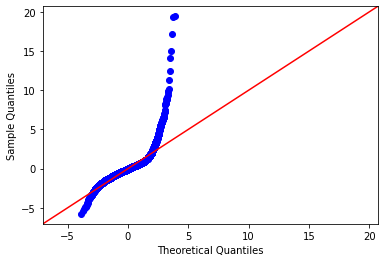

In [7]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

# Preprocessing #

In [ ]:
####: drop id & yrbuilt
### .608 - .611 (ols)
### trying to drop bathrooms as well to address potential mc
### .608, basically no difference
### drop just id and use yr_built as numeric
### .655, qq plot isn't greatest
##### id and yr_built are very gone
### drop id, yr_built, sqft_lot, 


In [8]:
continuous = ['sqft_living', 'sqft_lot']
categoricals = ['waterfront', 'bedrooms','grade', 'floors', 'bathrooms', 'condition']
kccat = kc_new[categoricals]
kccon = kc_new[continuous]


In [9]:
condition_ohe = pd.get_dummies(kccat['condition'], prefix = 'condition', drop_first=True)
waterfront_ohe =pd.get_dummies(kccat['waterfront'], prefix = 'waterfront', drop_first=True)
grade_ohe= pd.get_dummies(kccat['grade'], prefix = 'grade', drop_first=True)
bed_ohe= pd.get_dummies(kccat['bedrooms'], prefix = 'bed', drop_first=True)
bath_ohe= pd.get_dummies(kccat['bathrooms'], prefix = 'bath', drop_first=True)
floors_ohe= pd.get_dummies(kccat['floors'], prefix = 'floors', drop_first=True)


In [10]:
ohe_concat = pd.concat([waterfront_ohe, bed_ohe, grade_ohe, floors_ohe, bath_ohe, condition_ohe], axis = 1)
ohe_concat

,waterfront_1.0,bed_2,bed_3,bed_4,bed_5,bed_6,bed_7,bed_8,bed_9,bed_10,...,bath_6.25,bath_6.5,bath_6.75,bath_7.5,bath_7.75,bath_8.0,condition_2,condition_3,condition_4,condition_5
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
21593,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
21594,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
21595,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
price_log = np.log(kc_new['price'])
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

price_log_norm = normalize(price_log)
price_log_norm

0       -1.402879
1        0.278512
2       -1.800182
3        0.498200
4        0.177040
           ...   
21592   -0.484228
21593   -0.284199
21594   -0.274253
21595   -0.284199
21596   -0.678406
Name: price, Length: 21420, dtype: float64

In [12]:
# log and normalize features
log_names = [f'{column}_log' for column in kccon.columns]

kccon_log = np.log(kccon)
kccon_log.columns = log_names

log_names

['sqft_living_log', 'sqft_lot_log']

In [13]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

kc_log_norm = kccon_log.apply(normalize)

In [14]:
preprocessed = pd.concat([ohe_concat, kc_log_norm, price_log_norm], axis = 1)

In [15]:
preprocessed.columns = preprocessed.columns.str.replace('.','_')

In [16]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 62 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   waterfront_1_0   21420 non-null  uint8  
 1   bed_2            21420 non-null  uint8  
 2   bed_3            21420 non-null  uint8  
 3   bed_4            21420 non-null  uint8  
 4   bed_5            21420 non-null  uint8  
 5   bed_6            21420 non-null  uint8  
 6   bed_7            21420 non-null  uint8  
 7   bed_8            21420 non-null  uint8  
 8   bed_9            21420 non-null  uint8  
 9   bed_10           21420 non-null  uint8  
 10  bed_11           21420 non-null  uint8  
 11  bed_33           21420 non-null  uint8  
 12  grade_4          21420 non-null  uint8  
 13  grade_5          21420 non-null  uint8  
 14  grade_6          21420 non-null  uint8  
 15  grade_7          21420 non-null  uint8  
 16  grade_8          21420 non-null  uint8  
 17  grade_9     

In [17]:
X = preprocessed.drop(['price'], axis = 1)
y = preprocessed['price']
X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     552.7
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:18:31   Log-Likelihood:                -20248.
No. Observations:               21420   AIC:                         4.062e+04
Df Residuals:                   21358   BIC:                         4.111e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.7743      0.712     -1.087      0.277      -2.171       0.622
waterfront_1_0      1.1625      0.053     22.064      0.000       1.059       1.266
bed_2              -0.1297      0.049     -2.666      0.008      -0.225      -0.034
bed_3              -0.4080      0.049     -8.341      0.000      -0.504      -0.312
bed_4              -0.4491      0.050     -8.949      0.000      -0.547      -0.351
bed_5              -0.4534      0.053     -8.584      0.000      -0.557      -0.350
bed_6              -0.4830      0.064     -7.516      0.000      -0.609      -0.357
bed_7              -0.5505      0.116     -4.746      0.000      -0.778      -0.323
bed_8              -0.2266      0.183     -1.236      0.216      -0.586       0.133
bed_9               0.0141      0.286      0.049      0.961      -0.546       0.574
bed_10             -0.1923      0.369     -0.521      0.602      -0.915       0.531
bed_11             -0.3044      0.626     -0.486      0.627      -1.532       0.923
bed_33              0.3149      0.626      0.503      0.615      -0.912       1.542
grade_4            -0.4165      0.637     -0.654      0.513      -1.665       0.832
grade_5            -0.4218      0.630     -0.669      0.503      -1.657       0.814
grade_6            -0.1394      0.630     -0.221      0.825      -1.374       1.095
grade_7             0.2279      0.630      0.362      0.717      -1.007       1.463
grade_8             0.6281      0.630      0.997      0.319      -0.607       1.863
grade_9             1.0934      0.630      1.735      0.083      -0.142       2.329
grade_10            1.4505      0.631      2.300      0.021       0.214       2.687
grade_11            1.7677      0.631      2.800      0.005       0.530       3.005
grade_12            2.1855      0.635      3.444      0.001       0.942       3.429
grade_13            2.6722      0.661      4.045      0.000       1.377       3.967
floors_1_5          0.2894      0.016     18.085      0.000       0.258       0.321
floors_2_0         -0.0999      0.013     -7.807      0.000      -0.125      -0.075
floors_2_5          0.1745      0.051      3.422      0.001       0.075       0.274
floors_3_0          0.0560      0.029      1.900      0.057      -0.002       0.114
floors_3_5          0.0954      0.238      0.401      0.688      -0.371       0.562
bath_0_75           0.6567      0.322      2.041      0.041       0.026       1.287
bath_1_0            0.5819      0.312      1.863      0.062      -0.030       1.194
bath_1_25           0.4886      0.375      1.302      0.193      -0.247       1.224
bath_1_5            0.4705      0.313      1.504      0.133      -0.143       1.083
bath_1_75           0.5325      0.313      1.704      0.088      -0.080       1.145
bath_2_0            0.5153      0.313      1.648      0.099

## Baseline Train Model ##

In [18]:
X = preprocessed.drop(['price'], axis = 1)
y = preprocessed['price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(len(X_train), len(X_test), len(y_train), len(y_test))

16065 5355 16065 5355


In [19]:
X = X_train
y = y_train
X = sm.add_constant(X) # adding a constant

trainmodel = sm.OLS(y, X).fit()
predictions = trainmodel.predict(X) 

trainmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     428.0
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:18:41   Log-Likelihood:                -15159.
No. Observations:               16065   AIC:                         3.044e+04
Df Residuals:                   16005   BIC:                         3.090e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.6813      0.740     -0.920      0.357      -2.132       0.770
waterfront_1_0      1.2119      0.063     19.357      0.000       1.089       1.335
bed_2              -0.1517      0.056     -2.724      0.006      -0.261      -0.043
bed_3              -0.4296      0.056     -7.679      0.000      -0.539      -0.320
bed_4              -0.4638      0.057     -8.076      0.000      -0.576      -0.351
bed_5              -0.4887      0.060     -8.078      0.000      -0.607      -0.370
bed_6              -0.5952      0.074     -7.998      0.000      -0.741      -0.449
bed_7              -0.5202      0.135     -3.867      0.000      -0.784      -0.257
bed_8              -0.2866      0.211     -1.358      0.175      -0.700       0.127
bed_9               0.0680      0.447      0.152      0.879      -0.809       0.945
bed_10             -0.1463      0.461     -0.317      0.751      -1.051       0.758
bed_11             -0.3166      0.626     -0.506      0.613      -1.544       0.911
bed_33           4.276e-15   2.23e-15      1.921      0.055   -8.64e-17    8.64e-15
grade_4            -0.5977      0.643     -0.929      0.353      -1.859       0.664
grade_5            -0.4079      0.633     -0.644      0.519      -1.649       0.833
grade_6            -0.1502      0.632     -0.238      0.812      -1.390       1.089
grade_7             0.2198      0.632      0.347      0.728      -1.020       1.459
grade_8             0.6156      0.633      0.973      0.331      -0.624       1.856
grade_9             1.0796      0.633      1.706      0.088      -0.161       2.320
grade_10            1.4301      0.633      2.258      0.024       0.189       2.671
grade_11            1.7319      0.634      2.730      0.006       0.489       2.975
grade_12            2.1663      0.639      3.390      0.001       0.914       3.419
grade_13            2.8544      0.701      4.074      0.000       1.481       4.228
floors_1_5          0.2992      0.018     16.180      0.000       0.263       0.335
floors_2_0         -0.0936      0.015     -6.353      0.000      -0.122      -0.065
floors_2_5          0.2033      0.058      3.503      0.000       0.090       0.317
floors_3_0          0.0688      0.034      2.020      0.043       0.002       0.136
floors_3_5          0.1089      0.238      0.457      0.648      -0.358       0.576
bath_0_75           0.7590      0.373      2.033      0.042       0.027       1.491
bath_1_0            0.6867      0.360      1.905      0.057      -0.020       1.393
bath_1_25           0.6276      0.441      1.423      0.155      -0.237       1.492
bath_1_5            0.5876      0.361      1.628      0.104      -0.120       1.295
bath_1_75           0.6361      0.361      1.763      0.078      -0.071       1.343
bath_2_0            0.6264      0.361      1.736      0.083

In [20]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
preds = linreg.predict(X_train)

In [21]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [22]:
linreg.coef_

array([ 1.21185930e+00, -1.53462055e-01, -4.30886963e-01, -4.65098635e-01,
       -4.89815877e-01, -5.97166760e-01, -5.20201823e-01, -2.93397190e-01,
        6.42849926e-02, -1.49042562e-01, -3.18277412e-01,  2.66683181e+12,
       -6.01004634e-01, -4.06993463e-01, -1.49429914e-01,  2.21670199e-01,
        6.17548187e-01,  1.08164960e+00,  1.43204557e+00,  1.73072942e+00,
        2.16651884e+00,  2.85734618e+00,  2.98830484e-01, -9.37954406e-02,
        2.00821631e-01,  7.15846993e-02,  1.11126712e-01,  7.56411769e-01,
        6.87444255e-01,  6.30906318e-01,  5.88099084e-01,  6.35969299e-01,
        6.25948381e-01,  5.97682727e-01,  4.93087801e-01,  6.36607541e-01,
        6.40868425e-01,  7.84513038e-01,  7.11698690e-01,  9.20989310e-01,
        8.33311933e-01,  1.01726855e+00,  7.95432355e-01,  1.04257269e+00,
        1.09085373e+00,  7.85304426e-01,  1.03415480e+00,  1.24981649e+00,
        1.94337498e+00,  1.91810528e+00,  6.54305193e-01, -1.75443293e+08,
       -3.07259299e-01,  

In [23]:
linreg.intercept_

-0.6824648898344207

In [24]:
from sklearn.metrics import r2_score
r2_score(y_train, preds)

0.6120389713606142

In [25]:

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [26]:
result = stepwise_selection(X_train, y_train, verbose = True)
print('resulting features:')
print(result)

Add  sqft_living_log                with p-value 0.0
Add  grade_7                        with p-value 1.85158e-107
Add  grade_6                        with p-value 1.05157e-101
Add  grade_8                        with p-value 8.99495e-170
Add  grade_5                        with p-value 1.35861e-117
Add  bath_2_5                       with p-value 5.24117e-107
Add  waterfront_1_0                 with p-value 4.03935e-101
Add  floors_1_5                     with p-value 6.33074e-72
Add  grade_9                        with p-value 3.28756e-78
Add  bed_2                          with p-value 1.56757e-63
Add  condition_5                    with p-value 1.99783e-60
Add  sqft_lot_log                   with p-value 1.94488e-53
Add  condition_4                    with p-value 9.60314e-37
Add  grade_4                        with p-value 9.2125e-37
Add  grade_10                       with p-value 3.90709e-32
Add  floors_2_0                     with p-value 6.02599e-15
Add  grade_11              

In [27]:
len(result)

25

In [28]:
X_fin = X_train[result]
X_with_intercept = sm.add_constant(X_fin)
model = sm.OLS(y_train,X_with_intercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     997.9
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:19:19   Log-Likelihood:                -15228.
No. Observations:               16065   AIC:                         3.051e+04
Df Residuals:                   16039   BIC:                         3.071e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0415      0.013      3.203      0.001       0.016       0.067
sqft_living_log     0.4374      0.009     47.723      0.000       0.419       0.455
grade_7            -0.4082      0.013    -30.429      0.000      -0.435      -0.382
grade_6            -0.7687      0.023    -33.324      0.000      -0.814      -0.723
grade_5            -0.9840      0.051    -19.414      0.000      -1.083      -0.885
bath_2_5           -0.1421      0.013    -10.768      0.000      -0.168      -0.116
waterfront_1_0      1.2520      0.063     20.026      0.000       1.129       1.375
floors_1_5          0.2872      0.018     15.648      0.000       0.251       0.323
grade_9             0.4775      0.018     26.613      0.000       0.442       0.513
bed_2               0.2588      0.017     15.122      0.000       0.225       0.292
condition_5         0.3557      0.019     18.358      0.000       0.318       0.394
sqft_lot_log       -0.0988      0.006    -17.586      0.000      -0.110      -0.088
condition_4         0.1391      0.012     11.593      0.000       0.116       0.163
grade_4            -0.9961      0.149     -6.676      0.000      -1.289      -0.704
grade_10            0.8534      0.026     33.281      0.000       0.803       0.904
floors_2_0         -0.1001      0.013     -7.438      0.000      -0.126      -0.074
grade_11            1.2058      0.041     29.205      0.000       1.125       1.287
bath_1_0            0.0704      0.017      4.054      0.000       0.036       0.105
bath_3_75           0.2490      0.058      4.263      0.000       0.134       0.363
bath_3_25           0.1307      0.032      4.080      0.000       0.068       0.194
bath_4_25           0.3205      0.083      3.846      0.000       0.157       0.484
grade_13            2.6701      0.257     10.404      0.000       2.167       3.173
floors_2_5          0.2032      0.058      3.520      0.000       0.090       0.316
bath_6_0            1.2555      0.365      3.436      0.001       0.539       1.972
condition_2        -0.1913      0.057     -3.358      0.001      -0.303      -0.080
grade_12            1.6787      0.085     19.849      0.000       1.513       1.845
==============================================================================
Omnibus:                        5.129   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                5.393
Skew:                           0.013   Prob(JB):                       0.0674
Kurtosis:                       3.086   Cond. No.                         93.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

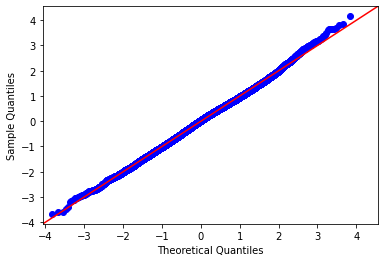

In [29]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [30]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)

In [31]:
from sklearn.metrics import mean_squared_error
test_residuals = y_hat_test - y_test

test_mse = mean_squared_error(y_test, y_hat_test)
test_mse

1.3281030711910586e+21

In [32]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

mse = make_scorer(mean_squared_error)

cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)

In [33]:
cv_5_results

array([4.04016870e-01, 2.37593624e+18, 1.70989913e+15, 3.90556569e-01,
       4.68942940e+21])

In [34]:
cv_5_results.mean()

9.383614100116286e+20

In [ ]:
## OK so that's a huge MSE, meaning we still have some fine tuning to do 

In [35]:
from scipy import stats
z = np.abs(stats.zscore(kc_new))
z

threshold = 3.5
print(np.where(z >= 3.5))

kc_new_out = kc_new[(z<=3.5).all(axis = 1)]
kc_new_out

(array([    5,    21,    36, ..., 21356, 21384, 21384], dtype=int64), array([4, 1, 8, ..., 5, 1, 7], dtype=int64))


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1955
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987
...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,3,2.50,1530,1131,3.0,0.0,3,8,2009
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,0.0,3,8,2014
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,0.0,3,7,2009
21595,291310100,400000.0,3,2.50,1600,2388,2.0,0.0,3,8,2004


In [36]:
continuous = ['sqft_living', 'sqft_lot']
categoricals = ['waterfront', 'bedrooms', 'floors', 'grade', 'bathrooms', 'condition']
kccat = kc_new_out[categoricals]
kccon = kc_new_out[continuous]


In [37]:
condition_ohe = pd.get_dummies(kccat['condition'], prefix = 'condition', drop_first=True)
waterfront_ohe =pd.get_dummies(kccat['waterfront'], prefix = 'waterfront', drop_first=True)
grade_ohe= pd.get_dummies(kccat['grade'], prefix = 'grade', drop_first=True)
bed_ohe= pd.get_dummies(kccat['bedrooms'], prefix = 'bed', drop_first=True)
bath_ohe= pd.get_dummies(kccat['bathrooms'], prefix = 'bath', drop_first=True)
floors_ohe= pd.get_dummies(kccat['floors'], prefix = 'floors', drop_first=True)


In [38]:
ohe_concat = pd.concat([waterfront_ohe, bed_ohe, floors_ohe, bath_ohe, grade_ohe, condition_ohe], axis = 1)
ohe_concat

,bed_2,bed_3,bed_4,bed_5,bed_6,floors_1.5,floors_2.0,floors_2.5,floors_3.0,bath_0.75,...,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,condition_3,condition_4,condition_5
0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
21593,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
21594,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
21595,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [39]:
price_log = np.log(kc_new_out['price'])
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

price_log_norm = normalize(price_log)
price_log_norm

0       -1.451898
1        0.373872
2       -1.883318
3        0.612425
4        0.263687
           ...   
21592   -0.454363
21593   -0.237158
21594   -0.226358
21595   -0.237158
21596   -0.665216
Name: price, Length: 20547, dtype: float64

In [40]:
# log and normalize features
log_names = [f'{column}_log' for column in kccon.columns]

kccon_log = np.log(kccon)
kccon_log.columns = log_names

log_names

['sqft_living_log', 'sqft_lot_log']

In [41]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

kc_log_norm = kccon_log.apply(normalize)

In [43]:
preprocessed2 = pd.concat([ohe_concat, kc_log_norm, price_log_norm], axis = 1)

In [44]:
preprocessed2.columns = preprocessed2.columns.str.replace('.','_')

In [45]:
preprocessed2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20547 entries, 0 to 21596
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bed_2            20547 non-null  uint8  
 1   bed_3            20547 non-null  uint8  
 2   bed_4            20547 non-null  uint8  
 3   bed_5            20547 non-null  uint8  
 4   bed_6            20547 non-null  uint8  
 5   floors_1_5       20547 non-null  uint8  
 6   floors_2_0       20547 non-null  uint8  
 7   floors_2_5       20547 non-null  uint8  
 8   floors_3_0       20547 non-null  uint8  
 9   bath_0_75        20547 non-null  uint8  
 10  bath_1_0         20547 non-null  uint8  
 11  bath_1_25        20547 non-null  uint8  
 12  bath_1_5         20547 non-null  uint8  
 13  bath_1_75        20547 non-null  uint8  
 14  bath_2_0         20547 non-null  uint8  
 15  bath_2_25        20547 non-null  uint8  
 16  bath_2_5         20547 non-null  uint8  
 17  bath_2_75   

In [46]:
X = preprocessed2.drop(['price'], axis = 1)
y = preprocessed2['price']
X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     674.8
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:21:09   Log-Likelihood:                -20822.
No. Observations:               20547   AIC:                         4.172e+04
Df Residuals:                   20508   BIC:                         4.203e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.3718      0.366     -3.744      0.000      -2.090      -0.654
bed_2              -0.1493      0.054     -2.783      0.005      -0.254      -0.044
bed_3              -0.4418      0.054     -8.189      0.000      -0.548      -0.336
bed_4              -0.4810      0.055     -8.690      0.000      -0.590      -0.373
bed_5              -0.4892      0.058     -8.390      0.000      -0.603      -0.375
bed_6              -0.4952      0.072     -6.862      0.000      -0.637      -0.354
floors_1_5          0.3121      0.018     17.775      0.000       0.278       0.347
floors_2_0         -0.1216      0.014     -8.566      0.000      -0.149      -0.094
floors_2_5          0.1508      0.060      2.515      0.012       0.033       0.268
floors_3_0          0.0173      0.033      0.531      0.595      -0.047       0.081
bath_0_75           0.7698      0.345      2.229      0.026       0.093       1.447
bath_1_0            0.6415      0.334      1.920      0.055      -0.013       1.297
bath_1_25           0.5607      0.409      1.371      0.170      -0.241       1.362
bath_1_5            0.5108      0.335      1.526      0.127      -0.145       1.167
bath_1_75           0.5839      0.334      1.746      0.081      -0.072       1.239
bath_2_0            0.5662      0.335      1.692      0.091      -0.090       1.222
bath_2_25           0.5375      0.335      1.606      0.108      -0.118       1.193
bath_2_5            0.4240      0.335      1.267      0.205      -0.232       1.080
bath_2_75           0.5583      0.335      1.667      0.096      -0.098       1.215
bath_3_0            0.5863      0.335      1.748      0.081      -0.071       1.244
bath_3_25           0.6754      0.336      2.010      0.044       0.017       1.334
bath_3_5            0.6640      0.336      1.978      0.048       0.006       1.322
bath_3_75           0.8221      0.341      2.414      0.016       0.155       1.490
bath_4_0            0.7060      0.343      2.061      0.039       0.034       1.378
bath_4_25           0.7888      0.351      2.246      0.025       0.100       1.477
bath_4_5            0.6204      0.346      1.794      0.073      -0.057       1.298
bath_4_75           0.6652      0.432      1.540      0.124      -0.182       1.512
grade_5            -0.0243      0.145     -0.168      0.867      -0.308       0.259
grade_6             0.2804      0.140      2.002      0.045       0.006       0.555
grade_7             0.6835      0.140      4.869      0.000       0.408       0.959
grade_8             1.1222      0.141      7.956      0.000       0.846       1.399
grade_9             1.6251      0.142     11.440      0.000       1.347       1.904
grade_10            1.9757      0.144     13.757      0.000       1.694       2.257
grade_11            2.2367      0.149     15.020      0.000

In [47]:
X = preprocessed2.drop(['price'], axis = 1)
y = preprocessed2['price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(len(X_train), len(X_test), len(y_train), len(y_test))

15410 5137 15410 5137


In [48]:
X = X_train
y = y_train
X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     506.1
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:21:36   Log-Likelihood:                -15579.
No. Observations:               15410   AIC:                         3.124e+04
Df Residuals:                   15371   BIC:                         3.153e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.2730      0.378     -3.364      0.001      -2.015      -0.531
bed_2              -0.1583      0.061     -2.593      0.010      -0.278      -0.039
bed_3              -0.4530      0.061     -7.369      0.000      -0.573      -0.332
bed_4              -0.4925      0.063     -7.806      0.000      -0.616      -0.369
bed_5              -0.5030      0.067     -7.563      0.000      -0.633      -0.373
bed_6              -0.4788      0.083     -5.781      0.000      -0.641      -0.316
floors_1_5          0.3149      0.020     15.626      0.000       0.275       0.354
floors_2_0         -0.1196      0.016     -7.312      0.000      -0.152      -0.088
floors_2_5          0.1651      0.069      2.382      0.017       0.029       0.301
floors_3_0          0.0201      0.038      0.526      0.599      -0.055       0.095
bath_0_75           0.6805      0.349      1.951      0.051      -0.003       1.364
bath_1_0            0.6425      0.334      1.926      0.054      -0.011       1.296
bath_1_25           0.5229      0.430      1.215      0.224      -0.321       1.366
bath_1_5            0.5184      0.334      1.551      0.121      -0.137       1.174
bath_1_75           0.5963      0.334      1.785      0.074      -0.058       1.251
bath_2_0            0.5705      0.334      1.707      0.088      -0.084       1.225
bath_2_25           0.5571      0.334      1.667      0.096      -0.098       1.212
bath_2_5            0.4295      0.334      1.285      0.199      -0.225       1.084
bath_2_75           0.5568      0.335      1.663      0.096      -0.099       1.213
bath_3_0            0.5808      0.335      1.732      0.083      -0.077       1.238
bath_3_25           0.6530      0.336      1.943      0.052      -0.006       1.312
bath_3_5            0.6911      0.336      2.059      0.040       0.033       1.349
bath_3_75           0.7673      0.342      2.245      0.025       0.097       1.437
bath_4_0            0.7200      0.346      2.083      0.037       0.043       1.398
bath_4_25           0.7534      0.355      2.119      0.034       0.057       1.450
bath_4_5            0.7229      0.349      2.074      0.038       0.040       1.406
bath_4_75           0.5629      0.511      1.101      0.271      -0.440       1.565
grade_5            -0.1053      0.174     -0.606      0.545      -0.446       0.236
grade_6             0.2043      0.170      1.205      0.228      -0.128       0.537
grade_7             0.5920      0.170      3.483      0.000       0.259       0.925
grade_8             1.0251      0.171      6.003      0.000       0.690       1.360
grade_9             1.5185      0.172      8.833      0.000       1.182       1.855
grade_10            1.8905      0.174     10.885      0.000       1.550       2.231
grade_11            2.1206      0.180     11.813      0.000

In [54]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
preds = linreg.predict(X_train)

In [55]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [56]:
linreg.coef_

array([-0.15833939, -0.45296829, -0.49247532, -0.50302899, -0.47881277,
        0.31488654, -0.11957762,  0.16509453,  0.02010192,  0.68049705,
        0.64253285,  0.52292011,  0.51836034,  0.59626079,  0.57052302,
        0.55707267,  0.42947403,  0.55678868,  0.58077201,  0.65303005,
        0.69111766,  0.76728591,  0.72004005,  0.75338156,  0.72290234,
        0.56293052, -0.10531422,  0.20429802,  0.59201336,  1.02511922,
        1.5184747 ,  1.89047858,  2.12060815,  0.22371077,  0.38766671,
        0.61378378,  0.46682764, -0.11892803])

In [57]:
linreg.intercept_

-1.272967211886982

In [58]:
from sklearn.metrics import r2_score
r2_score(y_train, preds)

0.5558109155360456

In [59]:
result = stepwise_selection(X_train, y_train, verbose = True)
print('resulting features:')
print(result)

Add  sqft_living_log                with p-value 0.0
Add  grade_7                        with p-value 1.32918e-102
Add  grade_6                        with p-value 9.59323e-124
Add  grade_8                        with p-value 2.47283e-117
Add  grade_5                        with p-value 1.00309e-135
Add  floors_1_5                     with p-value 8.26546e-92
Add  bed_2                          with p-value 3.23429e-70
Add  condition_5                    with p-value 2.12013e-65
Add  bath_2_5                       with p-value 4.54155e-57
Add  sqft_lot_log                   with p-value 2.45185e-58
Add  grade_9                        with p-value 7.65984e-46
Add  condition_4                    with p-value 2.74956e-40
Add  floors_2_0                     with p-value 1.03909e-16
Add  grade_11                       with p-value 5.97907e-08
Add  grade_10                       with p-value 7.0359e-27
Drop grade_6                        with p-value 0.859529
Add  bath_1_0                   

In [60]:
len(result)

19

In [61]:
X_fin = X_train[result]
X_with_intercept = sm.add_constant(X_fin)
model = sm.OLS(y_train,X_with_intercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     1003.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:23:09   Log-Likelihood:                -15624.
No. Observations:               15410   AIC:                         3.129e+04
Df Residuals:                   15390   BIC:                         3.144e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.9238      0.064    -14.394      0.000      -1.050      -0.798
sqft_living_log     0.4522      0.010     44.789      0.000       0.432       0.472
grade_7             0.3772      0.021     17.613      0.000       0.335       0.419
grade_8             0.8185      0.025     32.602      0.000       0.769       0.868
grade_5            -0.2655      0.053     -5.013      0.000      -0.369      -0.162
floors_1_5          0.3076      0.020     15.360      0.000       0.268       0.347
bed_2               0.2697      0.019     14.425      0.000       0.233       0.306
condition_5         0.6037      0.064      9.452      0.000       0.479       0.729
bath_2_5           -0.1540      0.015    -10.487      0.000      -0.183      -0.125
sqft_lot_log       -0.1226      0.006    -19.928      0.000      -0.135      -0.111
grade_9             1.3252      0.031     43.384      0.000       1.265       1.385
condition_4         0.3770      0.062      6.113      0.000       0.256       0.498
floors_2_0         -0.1248      0.015     -8.472      0.000      -0.154      -0.096
grade_11            1.9826      0.058     34.078      0.000       1.869       2.097
grade_10            1.7244      0.038     45.200      0.000       1.650       1.799
bath_1_0            0.0645      0.020      3.307      0.001       0.026       0.103
condition_3         0.2166      0.061      3.530      0.000       0.096       0.337
bath_3_5            0.0944      0.034      2.807      0.005       0.028       0.160
bath_1_5           -0.0634      0.023     -2.788      0.005      -0.108      -0.019
bed_4              -0.0337      0.013     -2.623      0.009      -0.059      -0.009
==============================================================================
Omnibus:                        2.837   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.242   Jarque-Bera (JB):                2.817
Skew:                          -0.026   Prob(JB):                        0.245
Kurtosis:                       3.041   Cond. No.                         34.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

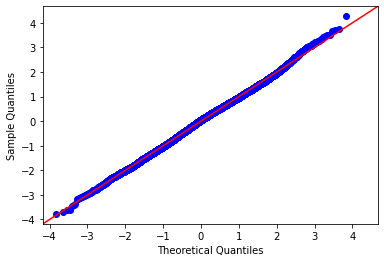

In [62]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [63]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)

In [64]:
from sklearn.metrics import mean_squared_error
test_residuals = y_hat_test - y_test

test_mse = mean_squared_error(y_test, y_hat_test)
test_mse

0.4516765524808653

In [65]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

mse = make_scorer(mean_squared_error)

cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)

In [66]:
cv_5_results.mean()

0.445287962313191

Much better MSE, although the R2 is lower, the QQ plot and Residual
scatter plots show the data is normalized and homoscedastic, giving us
a more accurate view of our data. 

# Ranked Feature Selection with Scikit #

In [67]:
from sklearn.feature_selection import RFE

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 20)
selector = selector.fit(X_fin, y_train.values.ravel()) # convert y to31d np array to prevent DataConversionWarning
selector.support_ 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [68]:
selected_columns = X_fin.columns[selector.support_ ]
linreg.fit(X_fin[selected_columns],y_train)

LinearRegression()

In [69]:
yhat = linreg.predict(X_fin[selected_columns])

In [70]:
SS_Residual = np.sum((y-yhat)**2)
SS_Total = np.sum((y-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X_fin[selected_columns].shape[1]-1)

In [71]:
r_squared

0.5531951239929946

In [72]:
adjusted_r_squared

0.5526435130349613

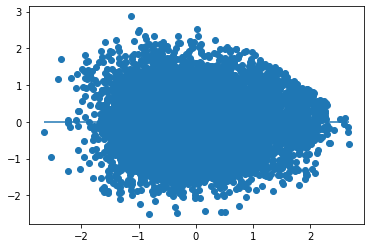

In [73]:
import matplotlib.pyplot as plt

residuals = y - preds

plt.scatter(preds, residuals)
plt.hlines(0, preds.min(), preds.max())
